In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os, sys

# ensure project root (one level up) is on PATH
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

## Load the video generator for tests

In [23]:
from utils.video_utils import read_video

video_path = "../sample_data/B1606b0e6_1 (91).mp4"
output_path = "../output_videos/output_video.avi"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

frame_generator = read_video(video_path)

## Augmentation functions

In [24]:
from annotators.player_annotator import PlayersAnnotator
from utils.notebook_utils import show_image
import random
import cv2

def random_fraction(frac_min=0.3, frac_max=0.7, step=0.1):
    """Return a random value from [frac_min, frac_max] in increments of step."""
    choices = [round(frac_min + i * step, 1)
               for i in range(int((frac_max - frac_min) / step) + 1)]
    return random.choice(choices)

def transform_image(frame, orientation='horizontal', alpha=1.5, beta=50, brighten=True):
    """
    Brighten or darken a slice of the frame.

    Args:
        frame (ndarray): Input image.
        orientation (str): 'horizontal' or 'vertical' slice to modify.
        alpha (float): Contrast multiplier when brightening; used as 1/alpha when darkening.
        beta (int): Brightness addition when brightening; subtracted when darkening.
        brighten (bool): If True, brighten the slice; if False, darken the slice.

    Returns:
        output (ndarray): Image with the selected slice modified.
        frac (float): Fraction of the image dimension used for the slice.
    """
    height, width = frame.shape[:2]
    frac = random_fraction()  # e.g. 0.3, 0.4, …, 0.7

    output = frame.copy()
    if orientation == 'horizontal':
        slice_height = int(frac * height)
        roi = output[0:slice_height, :]
        if brighten:
            # increase contrast and brightness
            output[0:slice_height, :] = cv2.convertScaleAbs(roi, alpha=alpha, beta=beta)
        else:
            # reduce contrast and subtract brightness
            dark = cv2.convertScaleAbs(roi, alpha=1.0/alpha, beta=0)
            output[0:slice_height, :] = cv2.subtract(dark, beta)

    else:  # vertical
        slice_width = int(frac * width)
        roi = output[:, 0:slice_width]
        if brighten:
            output[:, 0:slice_width] = cv2.convertScaleAbs(roi, alpha=alpha, beta=beta)
        else:
            dark = cv2.convertScaleAbs(roi, alpha=1.0/alpha, beta=0)
            output[:, 0:slice_width] = cv2.subtract(dark, beta)

    return output, frac

## Augmentations on one frame

Original image:


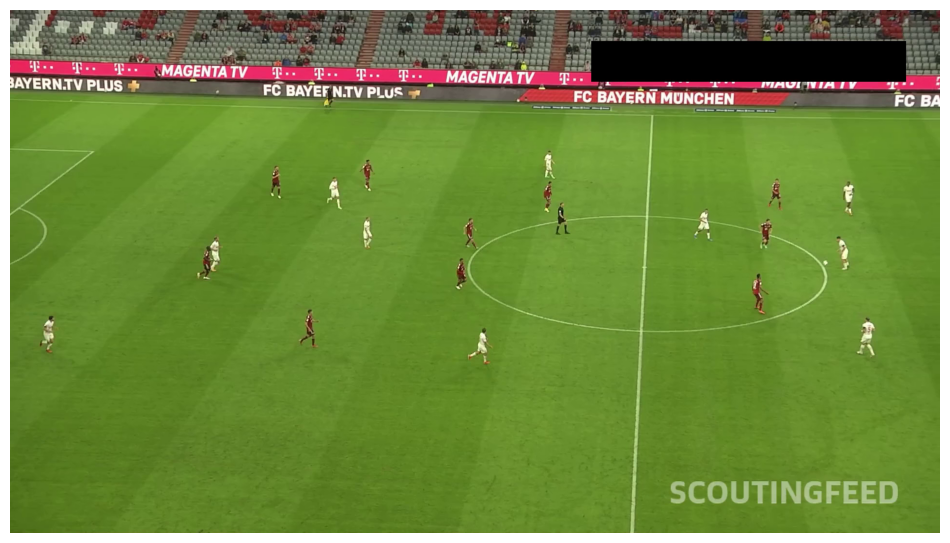

Horizontal slice darkened: 60% of image height


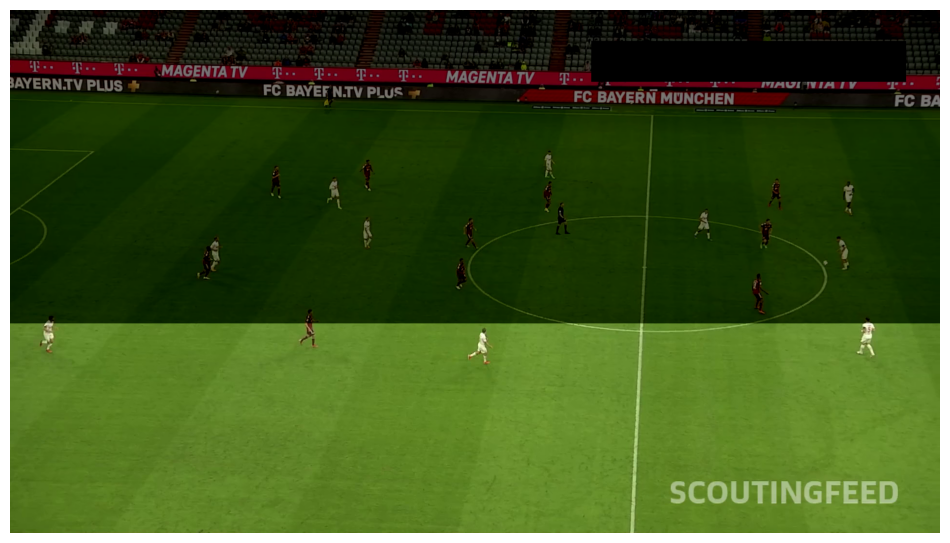

Vertical slice darkened: 40% of image width


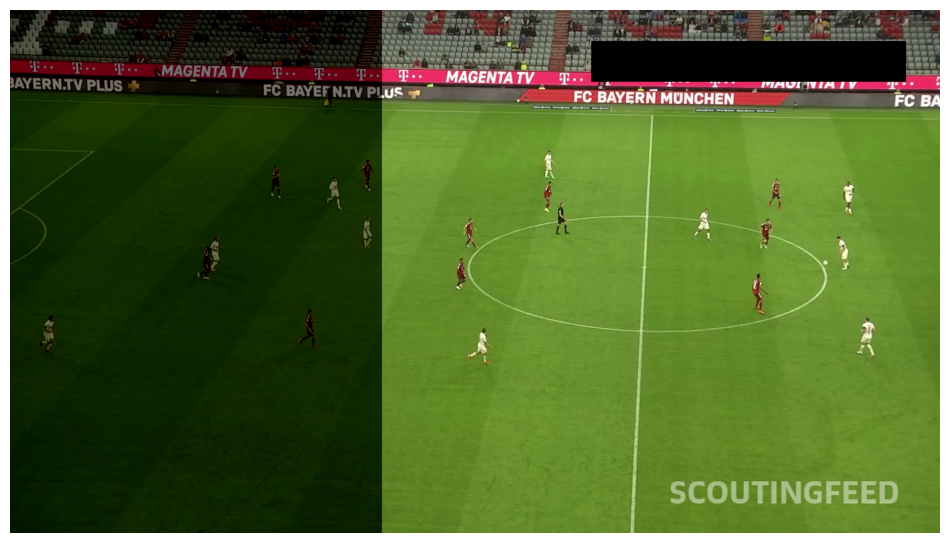

Horizontal slice brightened: 40% of image height


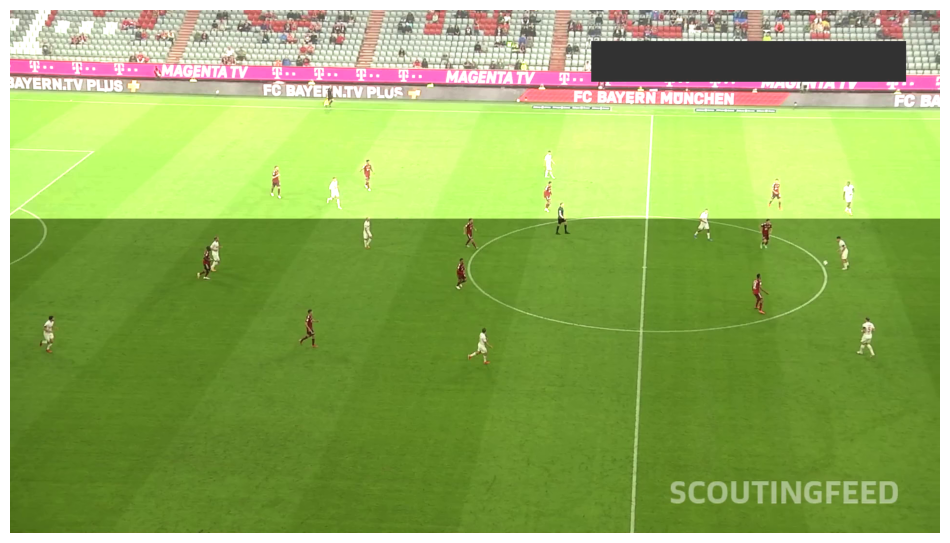

Vertical slice brightened: 30% of image width


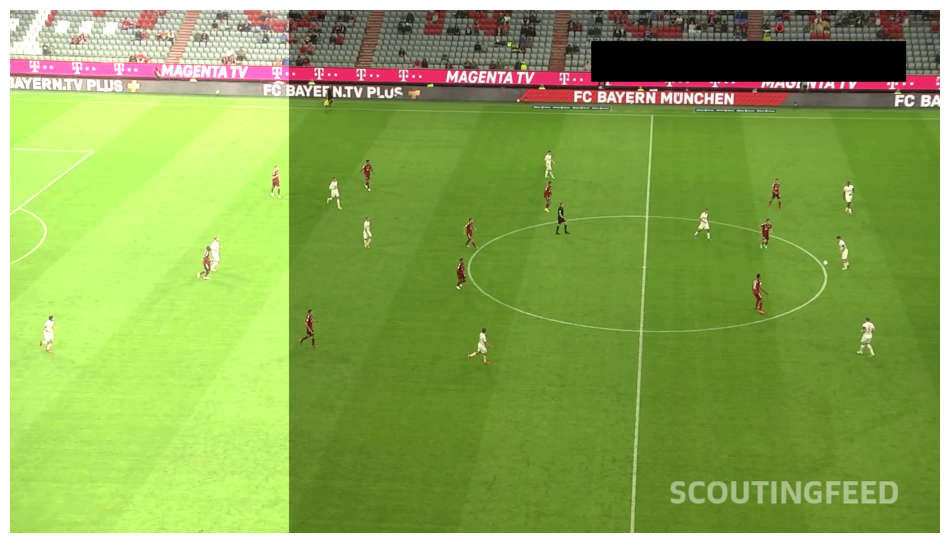

In [25]:
first_frame = next(frame_generator)

horizontal_bright_img, horizontal_bright_frac = transform_image(
    first_frame, orientation='horizontal', brighten=True
)
vertical_bright_img, vertical_bright_frac = transform_image(
    first_frame, orientation='vertical', brighten=True
)

horizontal_dark_img, horizontal_dark_frac = transform_image(
    first_frame, orientation='horizontal', brighten=False
)
vertical_dark_img, vertical_dark_frac = transform_image(
    first_frame, orientation='vertical', brighten=False
)

# Show the images
print("Original image:")
show_image(first_frame)

print(f"Horizontal slice darkened: {horizontal_dark_frac*100:.0f}% of image height")
show_image(horizontal_dark_img)
print(f"Vertical slice darkened: {vertical_dark_frac*100:.0f}% of image width")
show_image(vertical_dark_img)

print(f"Horizontal slice brightened: {horizontal_bright_frac*100:.0f}% of image height")
show_image(horizontal_bright_img)
print(f"Vertical slice brightened: {vertical_bright_frac*100:.0f}% of image width")
show_image(vertical_bright_img)

# Augment the dataset

## Prepare images and labels to perform augmentation


In [26]:
import shutil
import cv2
import os

images_path = "/home/gruzewson/Github/Github_PitchAnalyzer/PitchAnalyzer_AI/player_detection/train/images"
labels_path = "/home/gruzewson/Github/Github_PitchAnalyzer/PitchAnalyzer_AI/player_detection/train/labels"

# Get sorted lists of image and label files
image_files = sorted(os.listdir(images_path))
label_files = sorted(os.listdir(labels_path))

print("Image files:", image_files)
print("Label files:", label_files)

print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")

Image files: ['008e63fb-E3c993bd2_0_58_frame256.jpg', '01406044-test_5_frame363.jpg', '01cda8ca-C35bd9041_0_73_frame5.jpg', '01d2a654-C35bd9041_0_52_frame40.jpg', '02aa3872-A1606b0e6_0_49_frame636.jpg', '0552954a-test_6_frame279.jpg', '05c0897a-A1606b0e6_0_17_frame642.jpg', '065e43dc-E3c993bd2_0_61_frame733.jpg', '069b8afa-E3c993bd2_0_11_frame349.jpg', '07b45e4c-test_32_frame211.jpg', '080478f4-test_22_frame302.jpg', '0852eccb-E3c993bd2_0_76_frame426.jpg', '08fd33_0_1_png.rf.59954a0e7db57cb7481c52f01f7195e5.jpg', '08fd33_0_2_png.rf.6ea0cb4069331b557328bb65caa82328.jpg', '08fd33_0_3_png.rf.078bd1464102d6868657e90235976456.jpg', '08fd33_0_4_png.rf.09a8cfa8fd7af31db73ffd28ff957fb2.jpg', '08fd33_0_5_png.rf.d37e9b2517cf93852c9d8e76c97312c2.jpg', '08fd33_0_6_png.rf.63079e4bb39246d4cf50b64d9697a175.jpg', '08fd33_0_7_png.rf.7f7a191760b049100647fee7344250ac.jpg', '08fd33_3_1_png.rf.6f25c835bf6d1828dcf584e5969b1f58.jpg', '08fd33_3_2_png.rf.d3e93218821b1850744eed3be460fed3.jpg', '08fd33_3_3_png.r

## Perform augmentation

In [27]:
for i in range(0, len(image_files)):
    # Check if the names (without extensions) match
    if image_files[i].split(".")[0] == label_files[i].split(".")[0]:
        base_name = image_files[i].rsplit(".", 1)[0]
        image_path = os.path.join(images_path, image_files[i])
        label_path = os.path.join(labels_path, label_files[i])

        # Skip if the label file is empty
        if os.path.getsize(label_path) == 0:
            print(f"Skipping {label_files[i]}: empty label file.")
            continue

        # Read the image
        image = cv2.imread(image_path)

        # Brighten the image
        h_bright_img, h_bright_frac = transform_image(image, orientation='horizontal', brighten=True)
        v_bright_img, v_bright_frac = transform_image(image, orientation='vertical', brighten=True)

        # Darken the image
        h_dark_img, h_dark_frac = transform_image(image, orientation='horizontal', brighten=False)
        v_dark_img, v_dark_frac = transform_image(image, orientation='vertical', brighten=False)

        # Save the modified images
        h_bright_img_name = f"{base_name}_horizontal_bright_{h_bright_frac:.2f}.jpg"
        v_bright_img_name = f"{base_name}_vertical_bright_{v_bright_frac:.2f}.jpg"
        h_dark_img_name = f"{base_name}_horizontal_dark_{h_dark_frac:.2f}.jpg"
        v_dark_img_name = f"{base_name}_vertical_dark_{v_dark_frac:.2f}.jpg"

        h_bright_img_path = os.path.join(images_path, h_bright_img_name)
        v_bright_img_path = os.path.join(images_path, v_bright_img_name)
        h_dark_img_path = os.path.join(images_path, h_dark_img_name)
        v_dark_img_path = os.path.join(images_path, v_dark_img_name)

        cv2.imwrite(h_bright_img_path, h_bright_img)
        cv2.imwrite(v_bright_img_path, v_bright_img)
        cv2.imwrite(h_dark_img_path, h_dark_img)
        cv2.imwrite(v_dark_img_path, v_dark_img)

        # Copy the label files
        h_bright_lbl_name = f"{base_name}_horizontal_bright_{h_bright_frac:.2f}.txt"
        v_bright_lbl_name = f"{base_name}_vertical_bright_{v_bright_frac:.2f}.txt"
        h_dark_lbl_name = f"{base_name}_horizontal_dark_{h_dark_frac:.2f}.txt"
        v_dark_lbl_name = f"{base_name}_vertical_dark_{v_dark_frac:.2f}.txt"

        h_bright_lbl_path = os.path.join(labels_path, h_bright_lbl_name)
        v_bright_lbl_path = os.path.join(labels_path, v_bright_lbl_name)
        h_dark_lbl_path = os.path.join(labels_path, h_dark_lbl_name)
        v_dark_lbl_path = os.path.join(labels_path, v_dark_lbl_name)

        shutil.copy(label_path, h_bright_lbl_path)
        shutil.copy(label_path, v_bright_lbl_path)
        shutil.copy(label_path, h_dark_lbl_path)
        shutil.copy(label_path, v_dark_lbl_path)
        


# Get sorted lists of image and label files
image_files = sorted(os.listdir(images_path))
label_files = sorted(os.listdir(labels_path))

print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")




Number of images: 3260
Number of labels: 3260


In [28]:


# Verification: ensure every horizontal/vertical image has a non-empty label
print("\nVerification of augmented labels:")
for img_name in sorted(os.listdir(images_path)):
    if '_horizontal_' in img_name or '_vertical_' in img_name:
        base_name = img_name.rsplit('.', 1)[0]
        expected_label = os.path.join(labels_path, base_name + '.txt')
        if not os.path.exists(expected_label):
            print(f"Missing label for augmented image: {img_name}")
        elif os.path.getsize(expected_label) == 0:
            print(f"Empty label for augmented image: {img_name}")
        #else:
        #    print(f"OK: {img_name} has valid label.")

print("\nFinished.")



Verification of augmented labels:

Finished.
